# LIBRARIES

In [1]:
import numpy as np
import librosa
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
import random
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Data Preprocessing

## RAVDESS Dataset

In [2]:
ravdess = "RAVDESS"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)
file_emotion = []
file_path = []

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
# Loop though each actor folder
for folder in ravdess_directory_list:
    actor = os.listdir(ravdess + '/' + folder)

    # extract audio files for each actor folder
    for file in actor:
        part = file.split('.')[0].split('-')
        
        # The third part in each file name represents the emotion of that audio file
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + '/' + folder + '/' + file)

ravdess_df = pd.DataFrame({'Emotion': file_emotion, 
                           'Path': file_path})
ravdess_df

,Emotion,Path
0,1,RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
1,1,RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
2,1,RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
3,1,RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
4,2,RAVDESS/Actor_01/03-01-02-01-01-01-01.wav
...,...,...
1435,8,RAVDESS/Actor_24/03-01-08-01-02-02-24.wav
1436,8,RAVDESS/Actor_24/03-01-08-02-01-01-24.wav
1437,8,RAVDESS/Actor_24/03-01-08-02-01-02-24.wav
1438,8,RAVDESS/Actor_24/03-01-08-02-02-01-24.wav


In [4]:
ravdess_df["Emotion"] = ravdess_df["Emotion"].replace({1: 'neutral',
                                                       2: 'neutral',
                                                       3: 'happy',
                                                       4: 'sad',
                                                       5: 'angry',
                                                       6: 'fearful',
                                                       7: 'disgust',
                                                       8: 'surprised'})
print(ravdess_df["Emotion"].value_counts())

Emotion
neutral      288
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
Name: count, dtype: int64


## CREMA-D Dataset

In [5]:
crema = 'CREMA-D'
crema_directory_list = os.listdir(crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    part = file.split('.')[0].split('_')
    
    # The third part in each file name represents the emotion of that audio file
    file_emotion.append(part[2])
    file_path.append(crema + '/' + file)

crema_df = pd.DataFrame({'Emotion': file_emotion,
                         'Path': file_path})
crema_df

,Emotion,Path
0,ANG,CREMA-D/1001_DFA_ANG_XX.wav
1,DIS,CREMA-D/1001_DFA_DIS_XX.wav
2,FEA,CREMA-D/1001_DFA_FEA_XX.wav
3,HAP,CREMA-D/1001_DFA_HAP_XX.wav
4,NEU,CREMA-D/1001_DFA_NEU_XX.wav
...,...,...
7437,DIS,CREMA-D/1091_WSI_DIS_XX.wav
7438,FEA,CREMA-D/1091_WSI_FEA_XX.wav
7439,HAP,CREMA-D/1091_WSI_HAP_XX.wav
7440,NEU,CREMA-D/1091_WSI_NEU_XX.wav


In [6]:
crema_df["Emotion"] = crema_df["Emotion"].replace({'ANG': 'angry',
                                                   'DIS': 'disgust',
                                                   'FEA': 'fearful',
                                                   'HAP': 'happy',
                                                   'SAD': 'sad',
                                                   'NEU': 'neutral'})
print(crema_df["Emotion"].value_counts())

Emotion
angry      1271
disgust    1271
fearful    1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


## SAVEE dataset

In [7]:
savee = 'SAVEE'
savee_directory_list = os.listdir(savee)
print(savee_directory_list)

['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav', 'DC_a06.wav', 'DC_a07.wav', 'DC_a08.wav', 'DC_a09.wav', 'DC_a10.wav', 'DC_a11.wav', 'DC_a12.wav', 'DC_a13.wav', 'DC_a14.wav', 'DC_a15.wav', 'DC_d01.wav', 'DC_d02.wav', 'DC_d03.wav', 'DC_d04.wav', 'DC_d05.wav', 'DC_d06.wav', 'DC_d07.wav', 'DC_d08.wav', 'DC_d09.wav', 'DC_d10.wav', 'DC_d11.wav', 'DC_d12.wav', 'DC_d13.wav', 'DC_d14.wav', 'DC_d15.wav', 'DC_f01.wav', 'DC_f02.wav', 'DC_f03.wav', 'DC_f04.wav', 'DC_f05.wav', 'DC_f06.wav', 'DC_f07.wav', 'DC_f08.wav', 'DC_f09.wav', 'DC_f10.wav', 'DC_f11.wav', 'DC_f12.wav', 'DC_f13.wav', 'DC_f14.wav', 'DC_f15.wav', 'DC_h01.wav', 'DC_h02.wav', 'DC_h03.wav', 'DC_h04.wav', 'DC_h05.wav', 'DC_h06.wav', 'DC_h07.wav', 'DC_h08.wav', 'DC_h09.wav', 'DC_h10.wav', 'DC_h11.wav', 'DC_h12.wav', 'DC_h13.wav', 'DC_h14.wav', 'DC_h15.wav', 'DC_n01.wav', 'DC_n02.wav', 'DC_n03.wav', 'DC_n04.wav', 'DC_n05.wav', 'DC_n06.wav', 'DC_n07.wav', 'DC_n08.wav', 'DC_n09.wav', 'DC_n10.wav', 'DC_n11.wav', 'DC_n

In [8]:
file_emotion = []
file_path = []

for file in savee_directory_list:
    part = file.split('.')[0].split('_')
    file_emotion.append(part[1][:-2])
    file_path.append(savee + '/' + file)

savee_df = pd.DataFrame({'Emotion': file_emotion,
                         'Path': file_path})
savee_df

,Emotion,Path
0,a,SAVEE/DC_a01.wav
1,a,SAVEE/DC_a02.wav
2,a,SAVEE/DC_a03.wav
3,a,SAVEE/DC_a04.wav
4,a,SAVEE/DC_a05.wav
...,...,...
475,su,SAVEE/KL_su11.wav
476,su,SAVEE/KL_su12.wav
477,su,SAVEE/KL_su13.wav
478,su,SAVEE/KL_su14.wav


In [9]:
savee_df["Emotion"] = savee_df["Emotion"].replace({'n': 'neutral',
                          'd': 'disgust',
                          'a': 'angry',
                          'f': 'fearful',
                          'h': 'happy',
                          'sa': 'sad',
                          'su': 'surprised'})
print(savee_df["Emotion"].value_counts())

Emotion
neutral      120
angry         60
disgust       60
fearful       60
happy         60
sad           60
surprised     60
Name: count, dtype: int64


## TESS Dataset

In [10]:
tess = 'TESS'
tess_directory_list = os.listdir(tess)
print(tess_directory_list)

['OAF_angry', 'OAF_disgust', 'OAF_Fear', 'OAF_happy', 'OAF_neutral', 'OAF_Pleasant_surprise', 'OAF_Sad', 'YAF_angry', 'YAF_disgust', 'YAF_fear', 'YAF_happy', 'YAF_neutral', 'YAF_pleasant_surprised', 'YAF_sad']


In [11]:
file_emotion = []
file_path = []

# Loop though each emotion folder
for folder in tess_directory_list:
    files = os.listdir(tess + '/' + folder)

    # Extract each audio file
    for file in files:
        part = file.split('.')[0].split('_')
        file_emotion.append(part[2])
        file_path.append(tess + '/' + folder + '/' + file)

tess_df = pd.DataFrame({'Emotion': file_emotion,
                        'Path': file_path})
tess_df

,Emotion,Path
0,angry,TESS/OAF_angry/OAF_back_angry.wav
1,angry,TESS/OAF_angry/OAF_bar_angry.wav
2,angry,TESS/OAF_angry/OAF_base_angry.wav
3,angry,TESS/OAF_angry/OAF_bath_angry.wav
4,angry,TESS/OAF_angry/OAF_bean_angry.wav
...,...,...
2795,sad,TESS/YAF_sad/YAF_witch_sad.wav
2796,sad,TESS/YAF_sad/YAF_yearn_sad.wav
2797,sad,TESS/YAF_sad/YAF_yes_sad.wav
2798,sad,TESS/YAF_sad/YAF_young_sad.wav


In [12]:
tess_df["Emotion"] = tess_df["Emotion"].replace({'fear': 'fearful',
                         'ps': 'surprised'})
print(tess_df["Emotion"].value_counts())

Emotion
angry        400
disgust      400
fearful      400
happy        400
neutral      400
surprised    400
sad          400
Name: count, dtype: int64


In [13]:
combined_df = pd.concat([ravdess_df, savee_df, tess_df, crema_df])
print(combined_df["Emotion"].value_counts())

Emotion
happy        1923
sad          1923
angry        1923
fearful      1923
disgust      1923
neutral      1895
surprised     652
Name: count, dtype: int64


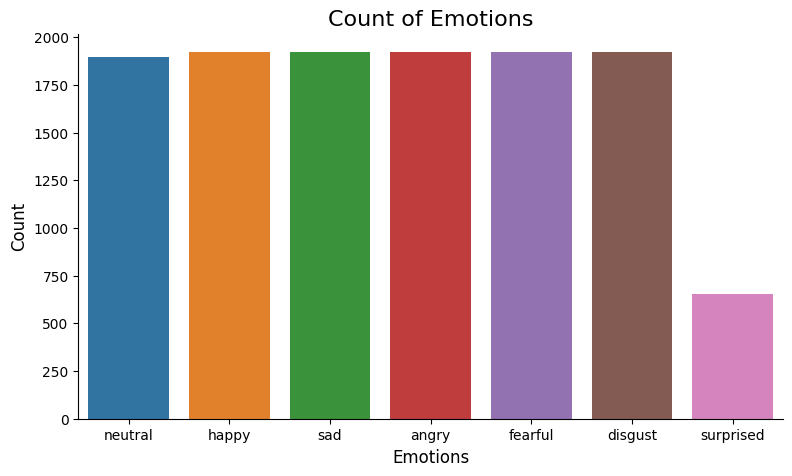

In [14]:
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(121)
plt.title('Count of Emotions', size=16)
sns.countplot(x=combined_df["Emotion"], hue=combined_df["Emotion"], legend=False)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

# Use augmentation to balance dataset

In [15]:
# combined_df = pd.read_csv("balanced_audio_dataset.csv")

# fig = plt.figure(figsize=(20, 5))

# fig.add_subplot(121)
# plt.title('Count of Emotions', size=16)
# sns.countplot(x=combined_df["Emotion"], hue=combined_df["Emotion"], legend=False)
# plt.ylabel('Count', size=12)
# plt.xlabel('Emotions', size=12)
# sns.despine(top=True, right=True, left=False, bottom=False)

# Data Augmentation


In [16]:
def noise(data, noise_factor=0.005):
    return data + noise_factor * np.random.randn(len(data))

def stretch(data, rate=random.uniform(0.9, 1.1)):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sr, n_steps=random.randint(-2, 2)):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def augment_audio(y, sr):
    return [
        noise(y),
        stretch(y),
        pitch(y, sr=sr)
    ]

### Data Augmentation example

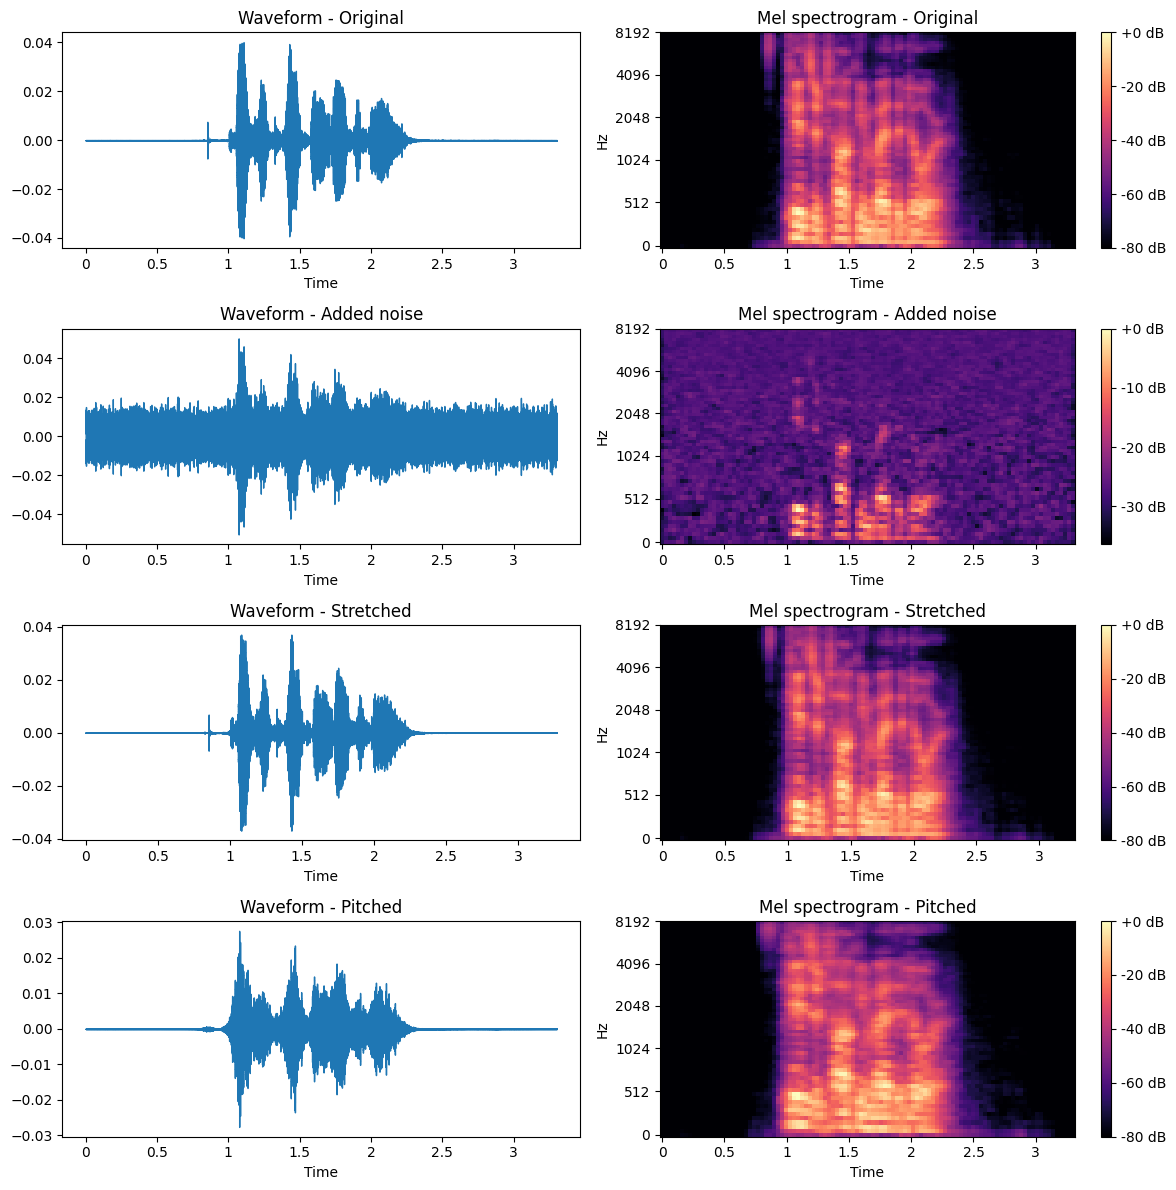

Original Audio:


Added Noise Audio:


Stretched Audio:


Pitched Audio:


In [17]:
example_file = combined_df["Path"].iloc[0]
y, sr = librosa.load(example_file, sr=16000)

added_noise, stretched, pitched = augment_audio(y, sr)

plt.figure(figsize=(12, 12))
for i, (title, data) in enumerate([
    ("Original", y),
    ("Added noise", added_noise),
    ("Stretched", stretched),
    ("Pitched", pitched)
]):
    # Waveform
    plt.subplot(4, 2, 2 * i + 1)
    librosa.display.waveshow(data, sr=sr)
    plt.title(f"Waveform - {title}")

    # Mel spectrogram
    plt.subplot(4, 2, 2 * i + 2)
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=64)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format="%+2.f dB")
    plt.title(f"Mel spectrogram - {title}")

plt.tight_layout()
plt.show()

# Play the examples
print("Original Audio:")
display(Audio(y, rate=sr))

print("Added Noise Audio:")
display(Audio(added_noise, rate=sr))

print("Stretched Audio:")
display(Audio(stretched, rate=sr))

print("Pitched Audio:")
display(Audio(pitched, rate=sr))

# Feature Extraction


In [18]:
def audio_to_melspectrogram_3d(y, sr=16000, n_mels=64, frame_length=2.0, fixed_n_frames=10, fixed_time_steps=65):
    """
    Convert audio waveform to a 3D array of mel-spectrograms with fixed shape.

    Args:
        y: NumPy array of audio waveform (shape: (n_samples,))
        sr: Sampling rate (default: 16000 Hz)
        n_mels: Number of mel bands (default: 64)
        frame_length: Length of each frame in seconds (default: 2.0)
        fixed_n_frames: Desired number of frames in output (default: 10)
        fixed_time_steps: (default:)

    Returns:
        NumPy array of shape (fixed_n_frames, n_mels, time_steps, channels=1)
    """
    # Normalize amplitude
    y = librosa.util.normalize(y)

    # Calculate samples per frame
    samples_per_frame = int(frame_length * sr)

    # Split audio into frames
    duration = len(y) / sr
    total_frames = int(np.ceil(duration / frame_length))  # Round up to include partial frames
    frames = []

    for i in range(total_frames):
        start = i * samples_per_frame
        end = min(start + samples_per_frame, len(y))
        y_frame = y[start:end]

        # Pad frame if too short
        if len(y_frame) < samples_per_frame:
            y_frame = np.pad(y_frame, (0, samples_per_frame - len(y_frame)), mode='constant')

        # Compute mel-spectrogram for the frame
        mel = librosa.feature.melspectrogram(
            y=y_frame, 
            sr=sr, 
            n_mels=n_mels,
            hop_length=int(samples_per_frame // (fixed_time_steps - 1)),  # Control time dimension
            n_fft=min(2048, samples_per_frame)
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Ensure consistent time dimension
        if mel_db.shape[1] < fixed_time_steps:
            # Pad with zeros
            pad_width = fixed_time_steps - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
        elif mel_db.shape[1] > fixed_time_steps:
            # Truncate
            mel_db = mel_db[:, :fixed_time_steps]

        frames.append(mel_db)

    # Convert to NumPy array and add channel dimension
    frames = np.array(frames)[..., np.newaxis,]  # Shape: (n_frames, n_mels, time_steps, channels=1)

    # Pad or truncate to fixed_n_frames
    current_n_frames = frames.shape[0]
    if current_n_frames < fixed_n_frames:
        # Pad with zero-filled spectrograms
        pad_shape = (fixed_n_frames - current_n_frames, n_mels, frames.shape[2], 1)
        padded_frames = np.zeros(pad_shape)
        frames = np.concatenate([frames, padded_frames], axis=0)
    elif current_n_frames > fixed_n_frames:
        # Truncate excess frames
        frames = frames[:fixed_n_frames]

    return frames

# Data Preparation

In [19]:
X = combined_df['Path']
y = combined_df['Emotion']

# 60% train, 20% valid, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [20]:
# Define emotion mappings
emotion_mapping = {'neutral': 0, 'happy': 1, 'sad': 2, 'angry': 3,
                    'fearful': 4, 'disgust': 5, 'surprised': 6}
reverse_mapping = {index: emotion for emotion, index in emotion_mapping.items()}

def process_audio(X, y, emotion_mapping, sr=16000):
    return (
        [audio_to_melspectrogram_3d(*librosa.load(per_X, sr=sr)) for per_X in X],
        [emotion_mapping[per_y] for per_y in y]
    )

# Process valid and test sets
processed_X_val, processed_y_val = process_audio(X_val, y_val, emotion_mapping)
processed_X_test, processed_y_test = process_audio(X_test, y_test, emotion_mapping)
X_val, y_val =np.array(processed_X_val), np.array(processed_y_val)
X_test, y_test = np.array(processed_X_test), np.array(processed_y_test)

In [21]:
# Augment and process training set
def audio_to_augmented_spectrograms(y, sr=16000):
    tensors = [audio_to_melspectrogram_3d(y, sr)]
    for aug in augment_audio(y, sr):
        tensors.append(audio_to_melspectrogram_3d(aug, sr))
    return tensors


new_X_train, new_y_train = [], []
for per_X, per_y in zip(X_train, y_train):
    y, sr = librosa.load(per_X, sr=16000)
    if np.random.rand() < 0.7:
        # 70% chance use only the original spectrogram
        tensor = audio_to_melspectrogram_3d(y, sr=sr)
        new_X_train.append(tensor)
        new_y_train.append(emotion_mapping[per_y])
    else:
        # 30% chance include all spectrograms (original + augmented)
        tensor = audio_to_augmented_spectrograms(y, sr=sr)
        new_X_train.extend(tensor)
        new_y_train.extend([emotion_mapping[per_y]] * len(tensor))

X_train, y_train = np.array(new_X_train), np.array(new_y_train)

In [22]:
# Reshape for Pytorch tensor input 
X_train = X_train.transpose(0, 4, 1, 2, 3)
X_val = X_val.transpose(0, 4, 1, 2, 3)
X_test = X_test.transpose(0, 4, 1, 2, 3)

# Pytorch: (number of samples, 1, fixed_n_frames, n_mels, time_steps)
# TF.Keras: (number of samples, fixed_n_frames, n_mels, time_steps, channels=1)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (13675, 1, 10, 64, 65)
Validation data shape: (2432, 1, 10, 64, 65)
Test data shape: (2433, 1, 10, 64, 65)


# Model

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from custom_3D_CNN import *
from timeit import default_timer

In [24]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=256, num_workers=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, num_workers=10)

# Training

### Train from scratch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class weights
classes = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
class_counts = np.array([1895, 1923, 1923, 1923, 1923, 1923, 652])
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(len(classes)), y=np.repeat(np.arange(len(classes)), class_counts))
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

model = Custom_3D_CNN(num_classes=len(emotion_mapping)).to(device)

num_epochs = 100
one_cycle_epochs = 20

#criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = FocalLoss(alpha=class_weights.to(device), gamma=2.0)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scaler = GradScaler()
plateau_scheduler  = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=1e-3, min_lr=1e-5)
one_cycle_scheduler  = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,                # 30% increase phase
    anneal_strategy='cos',        # Use cosine decay
    div_factor=10,                # initial_lr = max_lr / div_factor
    final_div_factor=1e4          # final_lr = max_lr / final_div_factor
)
early_stopping = EarlyStopping(patience=10, path='checkpoint.pth')

In [26]:
accuracies = {
    "train accuracy": [],
    "valid accuracy": []
}
losses = {
    "train loss": [],
    "valid loss": []
}

for epoch in range(num_epochs):
    # Train
    start_time = default_timer()
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        # Forward with Mixed Precision
        with autocast(device_type='cuda'):
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

        # Backward
        scaler.scale(loss).backward()
        # Unscale the gradients and clip
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimization step
        scaler.step(optimizer)
        scaler.update()

        # Update scheduler every batch if still in OneCycleLR phase
        if epoch < one_cycle_epochs:
            one_cycle_scheduler.step()

        train_loss += loss.item() * X_batch.size(0)  # multiply by batch size
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == y_batch).sum().item()
        train_total += y_batch.size(0)

    avg_train_loss = train_loss / train_total
    train_accuracy = train_correct / train_total
    accuracies["train accuracy"].append(train_accuracy)
    losses["train loss"].append(avg_train_loss)

    # Validation
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with autocast(device_type='cuda'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            valid_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            valid_correct += (predicted == y_batch).sum().item()
            valid_total += y_batch.size(0)

    avg_valid_loss = valid_loss / valid_total
    valid_accuracy = valid_correct / valid_total

    accuracies["valid accuracy"].append(valid_accuracy)
    losses["valid loss"].append(avg_valid_loss)

    # Step ReduceLROnPlateau per epoch, but only after OneCycleLR phase ends
    if epoch + 1 >= one_cycle_epochs:
        plateau_scheduler.step(avg_valid_loss)
    
    current_lr = optimizer.param_groups[0]["lr"]

    print(f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2%} | "
        f"Val Loss: {avg_valid_loss:.4f} | Val Acc: {valid_accuracy:.2%} | "
        f"LR: {current_lr:.6f} | {default_timer() - start_time:.2f}s")
    
    # Early stopping
    early_stopping(avg_valid_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping activated at epoch {epoch+1}")
        break

Epoch 1/100 | Train Loss: 1.4294 | Train Acc: 16.11% | Val Loss: 1.4104 | Val Acc: 19.78% | LR: 0.000102 | 35.91s
Epoch 2/100 | Train Loss: 1.4100 | Train Acc: 16.60% | Val Loss: 1.4078 | Val Acc: 16.20% | LR: 0.000110 | 28.93s
Epoch 3/100 | Train Loss: 1.4016 | Train Acc: 17.16% | Val Loss: 1.3946 | Val Acc: 17.31% | LR: 0.000122 | 29.04s
Epoch 4/100 | Train Loss: 1.3770 | Train Acc: 17.90% | Val Loss: 1.3324 | Val Acc: 17.85% | LR: 0.000139 | 30.07s
Epoch 5/100 | Train Loss: 1.2994 | Train Acc: 20.31% | Val Loss: 1.1830 | Val Acc: 22.57% | LR: 0.000160 | 29.50s
Epoch 6/100 | Train Loss: 1.2060 | Train Acc: 23.58% | Val Loss: 1.1478 | Val Acc: 28.04% | LR: 0.000186 | 30.29s
Epoch 7/100 | Train Loss: 1.1118 | Train Acc: 27.91% | Val Loss: 0.9724 | Val Acc: 35.81% | LR: 0.000216 | 30.64s
Epoch 8/100 | Train Loss: 1.0175 | Train Acc: 32.23% | Val Loss: 0.8617 | Val Acc: 41.24% | LR: 0.000249 | 32.05s
Epoch 9/100 | Train Loss: 0.9156 | Train Acc: 37.32% | Val Loss: 0.7632 | Val Acc: 45.31

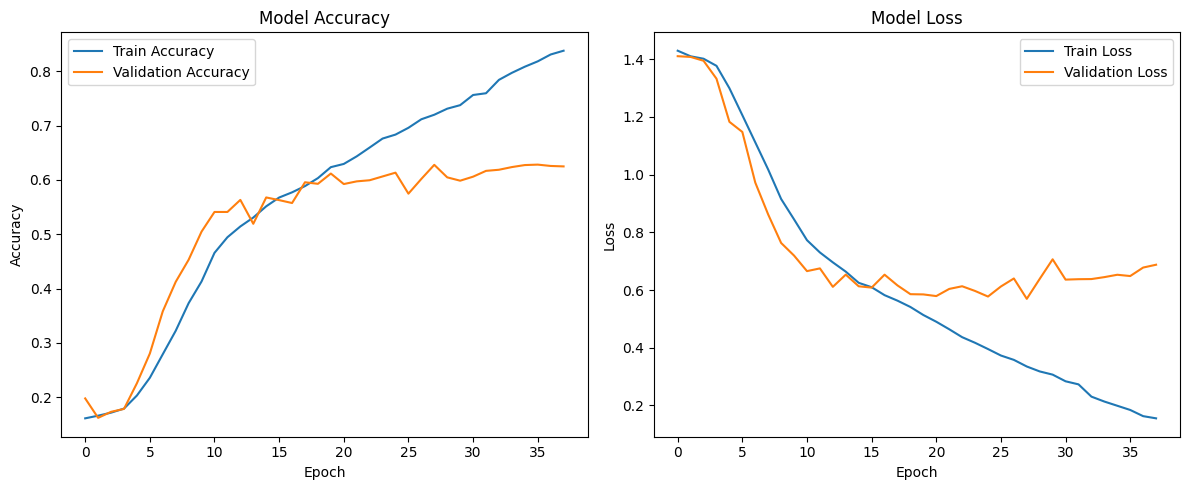

In [27]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracies["train accuracy"], label='Train Accuracy')
plt.plot(accuracies["valid accuracy"], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(losses['train loss'], label='Train Loss')
plt.plot(losses['valid loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Continue training

In [28]:
# Save model
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': avg_valid_loss
}, "best_model.pth")

# Model Evaluation

In [29]:
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=10, shuffle=True)

# Predict on test data
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_targets, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6264


Classification Report:
              precision    recall  f1-score   support

     neutral       0.64      0.66      0.65       379
       happy       0.56      0.58      0.57       385
         sad       0.61      0.59      0.60       385
       angry       0.71      0.72      0.72       385
     fearful       0.58      0.58      0.58       385
     disgust       0.60      0.53      0.56       384
   surprised       0.79      0.91      0.84       130

    accuracy                           0.63      2433
   macro avg       0.64      0.65      0.65      2433
weighted avg       0.62      0.63      0.62      2433



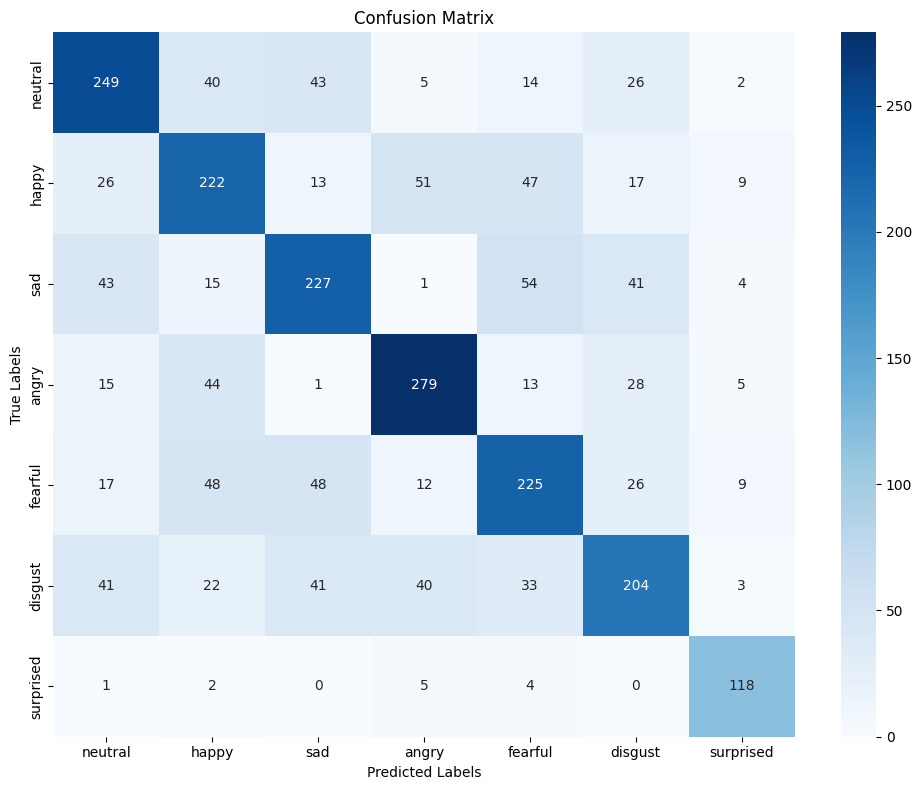

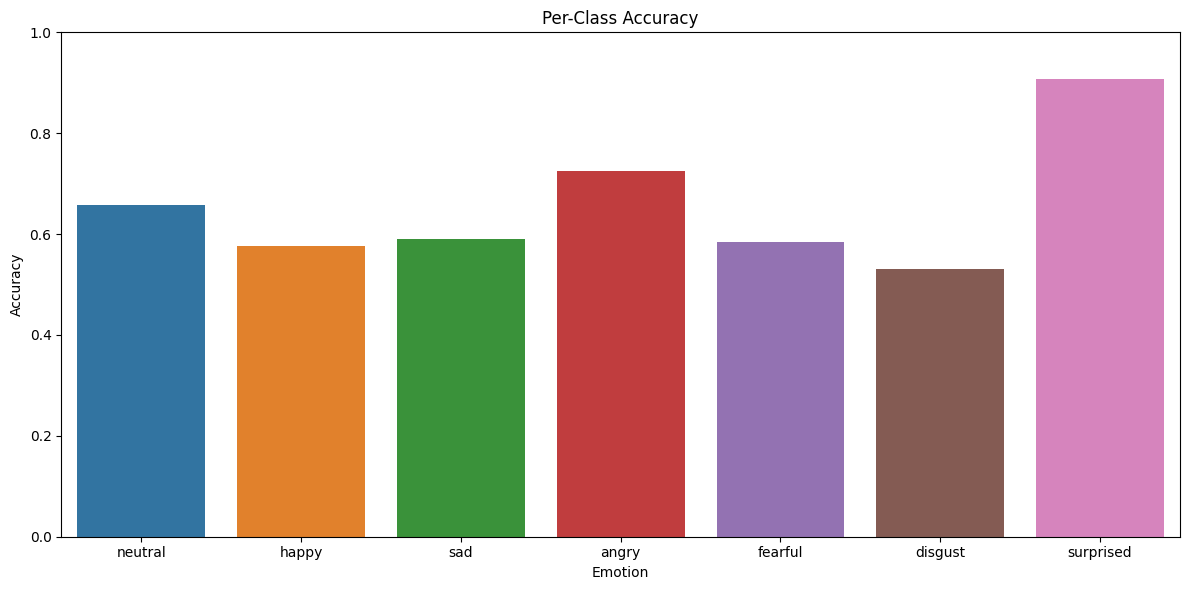

In [30]:
print("Classification Report:")
class_names = [reverse_mapping[i] for i in sorted(reverse_mapping.keys())]
report = classification_report(all_targets, all_preds, target_names=class_names)
print(report)

# Plot confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plot per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=per_class_accuracy, hue=class_names)
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()